In [1]:
%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import diffrax
import jax.numpy as jnp
import jax
import equinox as eqx
jax.config.update("jax_enable_x64", True)

/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


### Modeling a glucose pulse in Saccharomyces.
Thanks to alot of work from olga we have a pytorch implementation of glycolysis. We will now build the model slightly different, with a matrix S and fluxes v, but the fluxes are defined very similarly to the pytorch project. Workflow
1. Start inspecting data. C1: For glucose_EC, we might need to interpolate. See how we can do this in diffrax.

Index(['ECglucose', 'ECtreh', 'ICglucose', 'ICtreh', 'ICglyc', 'ICT6P',
       'ICUDPG', 'ICG1P', 'ICG6P', 'ICF6P', 'ICFBP', 'ICGAP', 'ICDHAP',
       'IC3PG', 'IC2PG', 'ICPEP', 'ICPYR', 'ICCIT', 'ICisoCIT', 'ICaKG',
       'ICSUCC', 'ICFUM', 'ICMAL', 'IC6PG', 'ICRibu5P', 'ICR5P', 'ICX5P',
       'ICS7P', 'ICE4P', 'ICM6P', 'ICG3P', 'ICATP', 'ICADP', 'ICAMP'],
      dtype='object')

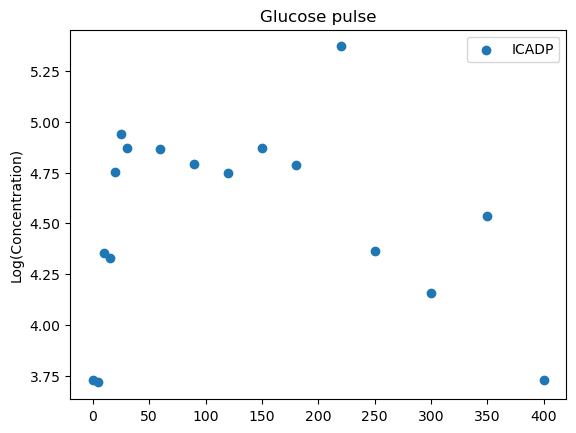

In [2]:
glycolysis_data=pd.read_csv("datasets/VanHeerden_Glucose_Pulse/FF1_timeseries_format.csv",index_col=0).T
time_points=[int(i) for i in glycolysis_data.index.to_list()]

# plt.scatter(time_points,glycolysis_data['ECglucose'],label="ECglucose")
# plt.scatter(time_points,glycolysis_data['ICglucose'],label="ICglucose")
# plt.scatter(time_points,glycolysis_data['ICtreh'],label="ICtreh")
plt.scatter(time_points,glycolysis_data['ICATP'],label="ICADP")
# plt.scatter(glycolysis_data.index,glycolysis_data['ICF6P'],label="ICF6P")
plt.legend()
plt.title("Glucose pulse")
plt.ylabel("Log(Concentration)")
# plt.yscale("symlog")
glycolysis_data.columns

Text(0.5, 1.0, 'Interpolation')

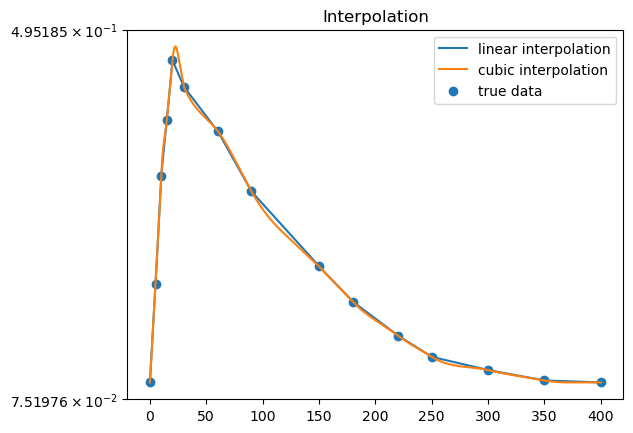

In [3]:
time_points=[int(i) for i in glycolysis_data.index.to_list()]



EC_glucose_missing=diffrax.linear_interpolation(ts=jnp.array(time_points),
                                                     ys=jnp.array(glycolysis_data['ECglucose']),
                                                     fill_forward_nans_at_end=True)
EC_glucose_interpolation_linear=diffrax.LinearInterpolation(ts=jnp.array(time_points),
                                                     ys=EC_glucose_missing)


coeffs=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ECglucose']),
                                             fill_forward_nans_at_end=True)



EC_glucose_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs)
                                                    #  ys=EC_glucose_missing)




new_ts=jnp.arange(0,400,0.001)
plt.plot(new_ts,EC_glucose_interpolation_linear.evaluate(t0=new_ts),label="linear interpolation")
plt.plot(new_ts,EC_glucose_interpolation_cubic.evaluate(t0=new_ts),label="cubic interpolation")

plt.scatter(time_points,glycolysis_data['ECglucose'],label="true data")
plt.yscale("symlog")
plt.legend()
plt.title("Interpolation")

In [4]:
from  source.kinetic_mechanisms.JaxKineticMechanisms import Jax_Facilitated_Diffusion,Jax_Irrev_MM_Uni
## set up a small term system for state variables
# S=pd.DataFrame(np.array([[-1,1,2]]),index=['ICglucose'],columns=['v_GLT','v_HXK','v_NTH1'])



S=pd.DataFrame(np.array([[1,-1]]),index=['ICglucose'],columns=['v_GLT','v_HXK'])

params={'p_GLT_KmGLTGLCi':1.0078,'p_GLT_KmGLTGLCo':1.0078,'p_GLT_VmGLT':8.1327,
       'p_HXK1_Kglc':0.3483,'p_HXK_Vmax':1 * 6.2548 *(1 + 0) }
for i in params:
     params[i]=jnp.array(params[i])

    




v_GLT=Jax_Facilitated_Diffusion('ECglucose','ICglucose',"p_GLT_VmGLT",'p_GLT_KmGLTGLCi','p_GLT_KmGLTGLCo')
v_HXK=Jax_Irrev_MM_Uni('ICglucose','p_HXK_Vmax','p_HXK1_Kglc')


In [12]:
glycolysis_data

,ECglucose,ECtreh,ICglucose,ICtreh,ICglyc,ICT6P,ICUDPG,ICG1P,ICG6P,ICF6P,...,ICRibu5P,ICR5P,ICX5P,ICS7P,ICE4P,ICM6P,ICG3P,ICATP,ICADP,ICAMP
0,0.094367,0.004125,0.196003,63.312040,NaN,0.093705,1.125963,0.064568,0.716385,0.202293,...,0.087637,0.190035,0.177087,3.237728,0.009485,0.227774,0.020586,3.730584,1.376832,0.431427
5,0.206601,0.004202,0.204943,65.302517,NaN,0.098474,1.214688,0.081634,1.066855,0.283083,...,0.091147,0.198049,0.185566,3.399768,0.009283,0.297514,0.013271,3.716214,1.483048,0.463653
10,0.329383,0.004247,0.197437,61.907062,NaN,0.086790,1.153021,0.083924,1.539130,0.398739,...,0.086962,0.188174,0.178342,3.212169,0.009480,0.396452,0.008149,4.351661,1.337193,0.360864
15,0.392714,0.004200,0.217031,61.755439,NaN,0.090381,1.145880,0.130255,2.145740,0.546338,...,0.083884,0.164407,0.180297,3.095420,0.008694,0.525473,0.024909,4.329230,1.262013,0.326028
20,0.460336,0.004532,0.218558,63.888053,NaN,0.081285,1.266437,0.166764,3.324030,0.871612,...,0.103783,0.211082,0.217049,3.256004,0.009485,0.812710,0.021138,4.753512,1.293071,0.314410
25,NaN,0.004265,0.221118,61.504080,NaN,0.091596,1.142878,0.154505,4.093288,1.102190,...,0.110069,0.219935,0.228371,2.980884,0.010131,0.994500,0.028754,4.941099,1.090067,0.261374
30,0.430515,0.003989,0.211016,60.290749,NaN,0.099388,1.241800,0.221412,4.849431,1.300741,...,0.122143,0.235020,0.255658,2.809072,0.011085,1.209468,0.027205,4.872260,0.949787,0.203678
60,0.380174,0.004112,0.206339,60.887713,NaN,0.419512,1.390029,0.272279,6.194068,1.696928,...,0.193286,0.279553,0.412920,2.314696,0.010202,1.817505,0.040806,4.866601,0.868837,0.194534
90,0.311412,0.004245,0.202804,62.025089,NaN,0.575306,1.587877,0.202877,5.421728,1.520833,...,0.234604,0.348868,0.495808,2.639445,0.010664,1.709150,0.049576,4.792161,1.059617,0.250142
120,NaN,0.003883,0.181807,62.723745,NaN,0.470424,1.835068,0.140918,4.191109,1.152367,...,0.226333,0.322697,0.487629,2.757427,0.009930,1.331983,0.040105,4.749100,1.060200,0.258565


In [9]:
def glycolysis(t,y,args):
    params,S,interp=args
    
    y=dict(zip(['ICglucose'],y))
    y['ECglucose']=interp.evaluate(t)
    
    eval_dict={**y,**params}

    rate_vGLT=v_GLT(eval_dict)
    rate_HXK=v_HXK(eval_dict)

    fluxes=jnp.array([rate_vGLT,rate_HXK])



    return jnp.matmul(S,fluxes)



term=diffrax.ODETerm(glycolysis)

ts=jnp.linspace(0,400,1000)

solver = diffrax.Kvaerno5()
saveat=diffrax.SaveAt(ts=ts)
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)



y=jnp.array([0.196003])

sol = diffrax.diffeqsolve(term, solver, t0=ts[0], t1=ts[-1], 
                          dt0=0.1, 
                          y0=y,
                          saveat=saveat,
                            stepsize_controller=stepsize_controller,
                            args=(params,jnp.array(S),
                                  EC_glucose_interpolation_cubic),
                            max_steps=10000)



5


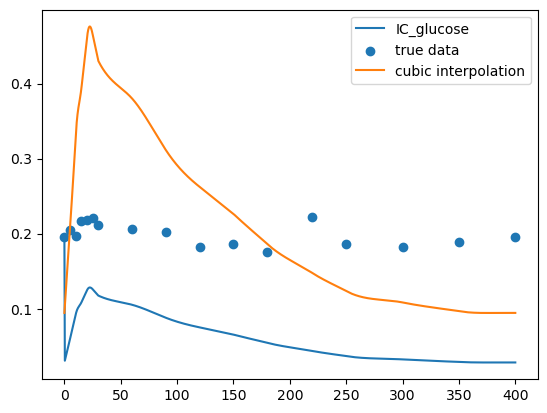

In [16]:
y=jnp.array([0.196003])

sol = diffrax.diffeqsolve(term, solver, t0=ts[0], t1=ts[-1], 
                          dt0=0.1, 
                          y0=y,
                          saveat=saveat,
                            stepsize_controller=stepsize_controller,
                            args=(params,jnp.array(S),
                                  EC_glucose_interpolation_cubic),
                            max_steps=10000)

plt.plot(sol.ts,sol.ys,label="IC_glucose")
plt.scatter(time_points,glycolysis_data['ICglucose'],label="true data")
plt.plot(new_ts,EC_glucose_interpolation_cubic.evaluate(t0=new_ts),label="cubic interpolation")
plt.legend()


print(len(params))